## Реализция RRT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import time
from rtree import index
import random


In [2]:
random.seed(42)

### Utilities

In [3]:
class Node:
    def __init__(self, x, y, cost=0, parent=None, child=None):
        self.x = x
        self.y = y
        self.parent = parent
        self.child = child
        self.cost = cost

In [4]:
class RectangleObstacle:
    def __init__(self, centers, side_sizes):
        self.centers = centers
        self.side_sizes = side_sizes
        self.bbox = self.get_bbox()
    
    def get_bbox(self):
        num_of_dimensions = len(self.centers)
        min_corner = np.empty(num_of_dimensions, float)
        max_corner = np.empty(num_of_dimensions, float)
        for j in range(num_of_dimensions):
            min_corner[j] = self.centers[j] - self.side_sizes[j]
            max_corner[j] = self.centers[j] + self.side_sizes[j]
        bbox = np.append(min_corner, max_corner)
        return tuple(bbox)
        
        

In [5]:
class CircleObstacle:
    def __init__(self, centers, radius):
        self.centers = centers
        self.radius = radius
        self.bbox = self.get_bbox()

    def get_bbox(self):
        num_of_dimensions = len(self.centers)
        min_corner = np.empty(num_of_dimensions, float)
        max_corner = np.empty(num_of_dimensions, float)
        for j in range(num_of_dimensions):
            min_corner[j] = self.centers[j] - self.radius
            max_corner[j] = self.centers[j] + self.radius
        bbox = np.append(min_corner, max_corner)
        return tuple(bbox)

In [6]:
class SearchSpace:
    def __init__(self, dimensions, num_obstacles, min_obstacle_size=0.05, max_obstacle_size=0.1):
        self.dimensions = dimensions 
        self.num_obstacles: int = num_obstacles
        self.min_obstacle_size = min_obstacle_size 
        self.max_obstacle_size = max_obstacle_size 

        p = index.Property()
        p.dimension = 2
        self.obstacles = index.Index(interleaved=True, properties=p)
        self.obstacles_list = []
        self.create_obstacle_map()

        
    def create_obstacle_map(self):
        num_of_dimensions = len(self.dimensions)
        i = 0
        while i < self.num_obstacles:
            center = np.empty(num_of_dimensions, float)
            sides_size = []

            obstacle_type = np.random.uniform(0, 1)

            if obstacle_type >= 0.5:
                for j, dimension in enumerate(self.dimensions):
                    min_side_length = dimension * self.min_obstacle_size
                    max_side_length = dimension * self.max_obstacle_size
                    side_size = random.uniform(min_side_length, max_side_length)
                    center[j] = random.uniform(side_size,
                                        dimension - side_size)
                    
                    sides_size.append(side_size)
                obstacle = RectangleObstacle(center, sides_size)

            else:
                radius = random.uniform(min(self.dimensions) * self.min_obstacle_size, max(self.dimensions) * self.max_obstacle_size)
                for j, dimension in enumerate(self.dimensions):
                    center[j] = random.uniform(radius,
                                        dimension - radius)
                obstacle = CircleObstacle(center, radius)

            self.obstacles_list.append(obstacle)
            self.obstacles.insert(i, obstacle.bbox, obstacle)

            i += 1

### Vanilla RRT

In [129]:
class RRT:
    def __init__(self, X: SearchSpace, start: tuple, goal: tuple, max_iter: int = 1000, step_size: float = 0.03, goal_radius: float = 0.5, go_bias=True, resolution=10):
        self.X: SearchSpace = X
        self.start: Node = start
        self.goal: Node = goal
        self.tree: list[Node] = [self.start]
        self.max_iter: int = max_iter
        self.step_size: float = min(X.dimensions) * step_size
        self.goal_radius = self.step_size * goal_radius
        self.go_bias = go_bias
        self.resolution = resolution # количество точек при проверке на коллизии

        p = index.Property()
        p.dimension = len(X.dimensions)
        self.V = index.Index(interleaved=True, properties=p)
        self.V_count = 0
        self.head = self.add_vertex(start, None)
        

        # Параметры для графика
        self.fig, self.ax = plt.subplots()
        self.frames = []


    def add_vertex(self, coords: tuple, parent: Node, cost=0):
        current = Node(coords[0], coords[1], parent=parent, cost=cost)
        if parent:
            parent.child = current
        self.V_count += 1
        self.V.insert(self.V_count, coords + coords, current)
        return current

    def get_nearest_node(self, point: tuple[float, float]) -> Node:
        nearest = list(self.V.nearest(point, 1, objects=True))[0]
        return nearest.object
        
    def get_k_nearest_nodes(self, point, k) -> list[Node]:
        k_nearest = list(self.V.nearest(point, k, objects=True))
        return k_nearest

    def get_random_point(self):
        go_bias_condition = np.random.uniform(0, 1)
        if go_bias_condition < 0.2:
            x = self.goal
        else:
            x = tuple(random.uniform(0, dimension) for dimension in self.X.dimensions)
        return x
    
    def is_collision_free(self, start, end):
        start, end = np.array(start), np.array(end)
        v = end - start
        u = v / (np.sqrt(np.sum(v ** 2))) # единичный вектор
        eps = self.step_size / (self.resolution + 1) # промежутков на 1 больше точек
        next_point = start
        for _ in range(self.resolution + 1):
            next_point += u * eps
            bbox_format = np.hstack((next_point, next_point))
            if self.X.obstacles.count(bbox_format) == 0:
                continue
            else:
                intersections = self.X.obstacles.intersection(bbox_format, objects=True)
                for item in intersections:
                    if type(item.object) == CircleObstacle:
                        if np.linalg.norm(item.object.centers - next_point <= item.object.radius):
                            return False
                    return False
        return True


    def steer(self, start: tuple, end: tuple) -> tuple:
        start, end = np.array(start), np.array(end)
        v = end - start
        u = v / (np.sqrt(np.sum(v ** 2))) # единичный вектор
        steered_point = start + u * self.step_size

        if self.is_collision_free(start, steered_point):
            return True, tuple(steered_point)
        return False, None
    

    def run_rrt(self):
        all_lines = []
        self.setup_visualization()
        self.frames.append([])

        for _ in range(self.max_iter):
            
            random_point = self.get_random_point()
            nearest_node = self.get_nearest_node(random_point)
            status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            # in case of collision
            while not status:
                random_point = self.get_random_point()
                nearest_node = self.get_nearest_node(random_point)
                status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            
            new_node = self.add_vertex(new_node, nearest_node)
            
            if new_node.parent:
                line, = self.ax.plot([new_node.x, new_node.parent.x], 
                                [new_node.y, new_node.parent.y], "-b")
                all_lines.append(line)
                self.frames.append(all_lines.copy())
            
            # check if we reached the goal
            if np.linalg.norm([new_node.x - self.goal[0], new_node.y - self.goal[1]]) < self.goal_radius:
                break

        return new_node

    def setup_visualization(self):
        
        self.ax.set_xlim(0, self.X.dimensions[0])
        self.ax.set_ylim(0, self.X.dimensions[1])

        for obstacle in self.X.obstacles_list:
            if type(obstacle) == RectangleObstacle:
                xmin, ymin, xmax, ymax = obstacle.bbox
                width = xmax - xmin
                height = ymax - ymin
                
                rect = patches.Rectangle((xmin, ymin), width, height, edgecolor='maroon', facecolor='indianred')
                self.ax.add_patch(rect)
                self.ax.add_artist(rect)
            else:
                circ = patches.Circle((obstacle.centers[0], obstacle.centers[1]), obstacle.radius, edgecolor='orangered', facecolor='darkorange', alpha=0.5)
                self.ax.add_patch(circ)
                
        
        self.ax.plot(self.start[0], self.start[1], 'bo', markersize=10, label='Start')
        self.ax.plot(self.goal[0], self.goal[1], 'ro', markersize=10, label='Goal')
        
        self.ax.grid(True)
        self.ax.legend()
        
        

 


In [9]:
def make_animation(frames, fig, outputfile_name):
    """
    Создание анимации
    """
    if not frames:
        raise Exception("Нет кадров для анимации")
    
    tree_animation = animation.ArtistAnimation(fig, frames, interval=50)
    
    tree_animation.save(outputfile_name, writer='pillow', fps=15)
    plt.show()    


Запустим наш Vanilla RRT с флагом `smart_step` (с вероятностью 0.2 в качестве рандомной точки берем итоговую точку)

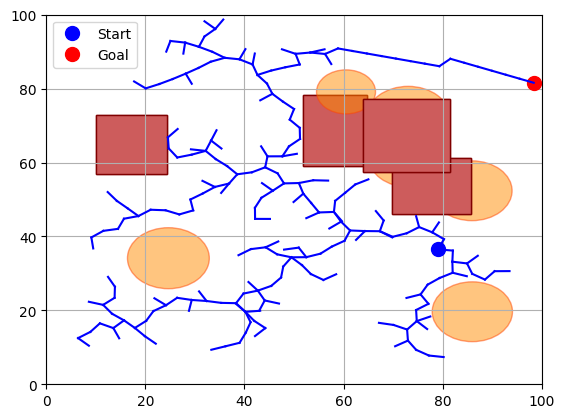

Animation completed and saved as rrt_go_bias.gif.


In [139]:
num_obstacles = 10  
map_size = [100, 100]

map = SearchSpace(map_size, num_obstacles)

start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
while not (map.obstacles.count(np.hstack((start + start))) == 0) or not (map.obstacles.count(np.hstack((goal + goal))) == 0):
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))

rrt = RRT(map, start, goal)

# Анимация
rrt.run_rrt()
make_animation(rrt.frames, rrt.fig, 'rrt_go_bias.gif')
print(f"Animation completed and saved as rrt_go_bias.gif.")

### RRT*

In [140]:
class RRTStar(RRT):
    def __init__ (self, X: SearchSpace, start: tuple, goal: tuple, max_iter: int = 1000, step_size: float = 0.03, goal_radius: float = 0.5, go_bias=True, resolution=10, rewire_cnt=1):
        super().__init__(X, start, goal, max_iter, step_size, goal_radius, go_bias, resolution)
        self.rewire_cnt = rewire_cnt

    def dist(self, point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    def cnt_path_cost(self, node1: Node, node2: Node):
        cost = 0
        while node2 != node1:
            if node2.parent is None:
                break
            current_node = node2.parent
            cost += self.dist((node2.x, node2.y), (current_node.x, current_node.y))
            node2 = current_node
        return cost
    
    def get_nearby_nodes(self, point):
        nearby_nodes = self.get_k_nearest_nodes(point, min(self.rewire_cnt, self.V_count))
        nearby_nodes_cost = [(item.object.cost + self.dist((item.object.x, item.object.y), point), item.object) for
                  item in nearby_nodes]
        return nearby_nodes_cost
    
    def rewire(self, new_node, nearby_nodes):
        for cost, node in nearby_nodes:
            curr_cost = node.cost
            tent_cost = new_node.cost + self.dist((new_node.x, new_node.y), (node.x, node.y))
            if tent_cost < curr_cost and self.is_collision_free((node.x, node.y), (new_node.x, new_node.y)):
                node.parent = new_node
                node.cost = tent_cost
                
    def choose_parent(self, point, nearby_nodes):
        min_cost = float('inf')
        best_parent = None
        
        for distance, node in nearby_nodes:
            if distance < min_cost:
                min_cost = distance
                best_parent = node
                
        return best_parent
    def run_rrt_star(self):
        all_lines = []
        self.setup_visualization()
        self.frames.append([])

        for _ in range(self.max_iter):
            
            
            random_point = self.get_random_point()
            nearest_node = self.get_nearest_node(random_point)
            status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            # in case of collision
            while not status:
                random_point = self.get_random_point()
                nearest_node = self.get_nearest_node(random_point)
                status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            nearest_nodes = self.get_nearby_nodes(new_node)
            best_parent = self.choose_parent(new_node, nearest_nodes)
            cost = best_parent.cost + self.dist((best_parent.x, best_parent.y), new_node)
            new_node = self.add_vertex(new_node, best_parent, cost=best_parent.cost + self.dist((best_parent.x, best_parent.y), new_node))
            new_node.cost = cost
    
            self.rewire(new_node, nearest_nodes)

            
            if new_node.parent:
                line, = self.ax.plot([new_node.x, new_node.parent.x], 
                                [new_node.y, new_node.parent.y], "-b")
                all_lines.append(line)
                self.frames.append(all_lines.copy())
            
            # check if we reached the goal
            if np.linalg.norm([new_node.x - self.goal[0], new_node.y - self.goal[1]]) < self.goal_radius:
                break

        return new_node
        




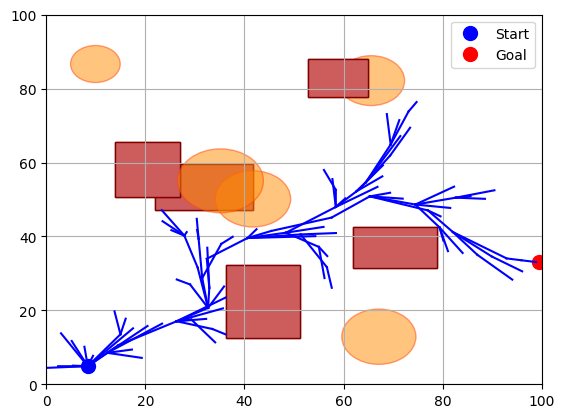

Animation completed and saved as rrt_star.gif.


In [143]:
num_obstacles = 10
map_size = [100, 100]

map = SearchSpace(map_size, num_obstacles)

start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
while not (map.obstacles.count(np.hstack((start + start))) == 0) or not (map.obstacles.count(np.hstack((goal + goal))) == 0):
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))

rrt_star = RRTStar(map, start, goal, rewire_cnt=5)

# Анимация
rrt_star.run_rrt_star()
make_animation(rrt_star.frames, rrt_star.fig, 'rrt_star.gif')
print(f"Animation completed and saved as rrt_star.gif.")

### Сравнение RRT и RRT*

In [35]:
def calculate_path_length(node):
    length = 0
    current = node
    while current.parent:
        length += np.linalg.norm([current.x - current.parent.x, 
                                current.y - current.parent.y])
        current = current.parent
    return length

In [126]:
RANDOM_SEED = 23
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


map_size = [100, 100]
num_obstacles = 10
map = SearchSpace(map_size, num_obstacles)

start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
while not (map.obstacles.count(np.hstack((start + start))) == 0) or not (map.obstacles.count(np.hstack((goal + goal))) == 0):
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
        
# RRT
start_time = time.time()
rrt = RRT(map, start, goal)
rrt_tail = rrt.run_rrt()
rrt_time = time.time() - start_time
print('rrt time', rrt_time)
print('rrt path length', calculate_path_length(rrt_tail))

# RRT*
start_time = time.time()
rrt_star = RRTStar(map, start, goal)
rrt_star_tail = rrt_star.run_rrt_star()
rrt_star_time = time.time() - start_time
print('rrt star time', rrt_star_time)
print('rrt star path length', rrt_star_tail.cost)



rrt time 0.1392371654510498
rrt path length 138.0
rrt star time 0.041810035705566406
rrt star path length 123.0
